In [ ]:
import cv2
import random
import os
import matplotlib.pyplot as plt

In [ ]:
sizes = ["128", "256", "384", "512"]
for size in sizes:
    for file in os.scandir(f"videos/LDV3dataset/validation/cropped_{size}"):
        if not file.is_file():
            continue

        file_name, file_extension = os.path.splitext(file.name)
        vidcap_ground_truth = cv2.VideoCapture(file.path)
        vidcap_downscaled_half = cv2.VideoCapture(f"videos/LDV3dataset/validation/cropped_{size}/downscaled_0.5/{file_name}_downscaled_0.5.mkv")
        vidcap_downscaled_qrt = cv2.VideoCapture(f"videos/LDV3dataset/validation/cropped_{size}/downscaled_0.25/{file_name}_downscaled_0.25.mkv")

        total_frames = vidcap_ground_truth.get(cv2.CAP_PROP_FRAME_COUNT)
        for i in range(0, 10):
            rand_frame = random.randint(0, total_frames)
            vidcap_ground_truth.set(cv2.CAP_PROP_POS_FRAMES, rand_frame)
            success, image_gt = vidcap_ground_truth.read()
            if success:
                cv2.imwrite(f"videos/LDV3dataset/validation/cropped_{size}/{file.name}_rf_{rand_frame}.jpg", image_gt)

            vidcap_downscaled_half.set(cv2.CAP_PROP_POS_FRAMES, rand_frame)
            success, image_ds = vidcap_downscaled_half.read()
            if success:
                cv2.imwrite(f"videos/LDV3dataset/validation/cropped_{size}/downscaled_0.5/{file.name}_rf_{rand_frame}.jpg", image_ds)

            vidcap_downscaled_qrt.set(cv2.CAP_PROP_POS_FRAMES, rand_frame)
            success, image_ds = vidcap_downscaled_qrt.read()
            if success:
                cv2.imwrite(f"videos/LDV3dataset/validation/cropped_{size}/downscaled_0.25/{file.name}_rf_{rand_frame}.jpg", image_ds)
            print(f'saved {file.name}_rf_{rand_frame}.jpg')

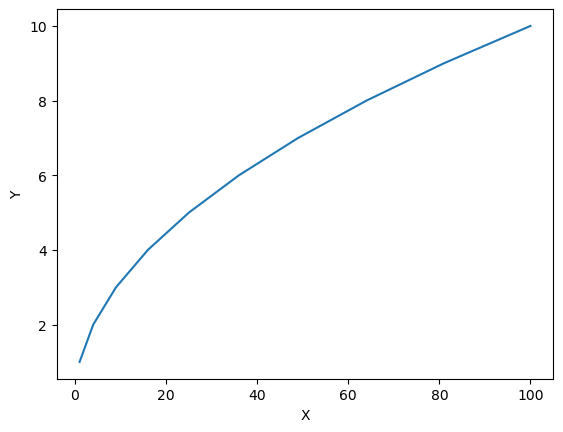

using device cuda
using device 1


C:\Users\Dino\.conda\envs\thesis3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dino\.conda\envs\thesis3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_146_grid_0.25.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_146_grid_0.5.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_150_grid_0.25.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_150_grid_0.5.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_175_grid_0.25.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_175_grid_0.5.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_184_grid_0.25.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_184_grid_0.5.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_2_grid_0.25.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_2_grid_0.5.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_208_grid_0.25.jpg
saved videos/LDV3dataset/validation/cropped_384/005_384.mkv_rf_208_grid_0.5.jpg
saved videos/LDV3dataset/validation/cr

In [15]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import transforms
from models.ImageMetrics import ImageMetrics
import numpy as np
import lpips
import torch
from modes.ApplicationHelpers import torch_setup_cuda

torch_setup_cuda()
model = lpips.LPIPS(net='vgg', verbose=False)

sizes = [384, 512]
downscales=[0.25, 0.5]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for size in sizes:
    for file in os.scandir(f"videos/LDV3dataset/validation/cropped_{size}"):
        file_name, file_extension = os.path.splitext(file.name)
        if file_extension != '.jpg' or 'grid' in file_name or 'interpolation' in file_name:
            continue

        for downscale in downscales:
            image = Image.open(f"videos/LDV3dataset/validation/cropped_{size}/downscaled_{downscale}/{file_name}{file_extension}")
            image_gt = Image.open(file.path)

            nn_exact = transforms.Resize(size=(size, size), interpolation=transforms.InterpolationMode.NEAREST_EXACT).forward(image)
            nn = transforms.Resize(size=(size, size), interpolation=transforms.InterpolationMode.NEAREST).forward(image)
            linear = transforms.Resize(size=(size, size), interpolation=transforms.InterpolationMode.BILINEAR).forward(image)
            cubic =  transforms.Resize(size=(size, size), interpolation=transforms.InterpolationMode.BICUBIC).forward(image)
            lanczos =  transforms.Resize(size=(size, size), interpolation=transforms.InterpolationMode.LANCZOS).forward(image)

            fig = plt.figure(figsize=(11., 11.), dpi=100)
            grid = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0.10, aspect=False)

            metrics = []
            for ax, im, title in zip(grid, [image_gt, nn, nn_exact, linear, cubic, lanczos], ['ground-truth', 'nearest', 'nearest-exact', 'bilinear', 'bicubic', 'lanczos']):
                ax.axis('off')
                ax.set_title(title)
                ax.matshow(np.array(im))

                if title == 'ground-truth':
                    continue

                metrics.append(ImageMetrics.metric_export(np.array(image_gt), np.array(im), title, model))
            ImageMetrics.metric_export_all(metrics, f"videos/LDV3dataset/validation/cropped_{size}/{file_name}_grid_{downscale}")
            plt.savefig(f"videos/LDV3dataset/validation/cropped_{size}/{file_name}_grid_{downscale}.jpg")
            print(f"saved videos/LDV3dataset/validation/cropped_{size}/{file_name}_grid_{downscale}.jpg")
            plt.close(fig)


['videos/LDV3dataset/validation/cropped_512/362_512.mkv_rf_119.jpg', 'videos/LDV3dataset/validation/cropped_512/221_512.mkv_rf_197.jpg', 'videos/LDV3dataset/validation/cropped_512/324_512.mkv_rf_192.jpg', 'videos/LDV3dataset/validation/cropped_512/331_512.mkv_rf_134.jpg', 'videos/LDV3dataset/validation/cropped_512/076_512.mkv_rf_317.jpg', 'videos/LDV3dataset/validation/cropped_512/300_512.mkv_rf_123.jpg', 'videos/LDV3dataset/validation/cropped_512/045_512.mkv_rf_131.jpg', 'videos/LDV3dataset/validation/cropped_512/013_512.mkv_rf_5.jpg', 'videos/LDV3dataset/validation/cropped_512/204_512.mkv_rf_277.jpg', 'videos/LDV3dataset/validation/cropped_512/026_512.mkv_rf_128.jpg', 'videos/LDV3dataset/validation/cropped_512/250_512.mkv_rf_282.jpg', 'videos/LDV3dataset/validation/cropped_512/110_512.mkv_rf_405.jpg', 'videos/LDV3dataset/validation/cropped_512/150_512.mkv_rf_412.jpg', 'videos/LDV3dataset/validation/cropped_512/184_512.mkv_rf_88.jpg', 'videos/LDV3dataset/validation/cropped_512/081_512

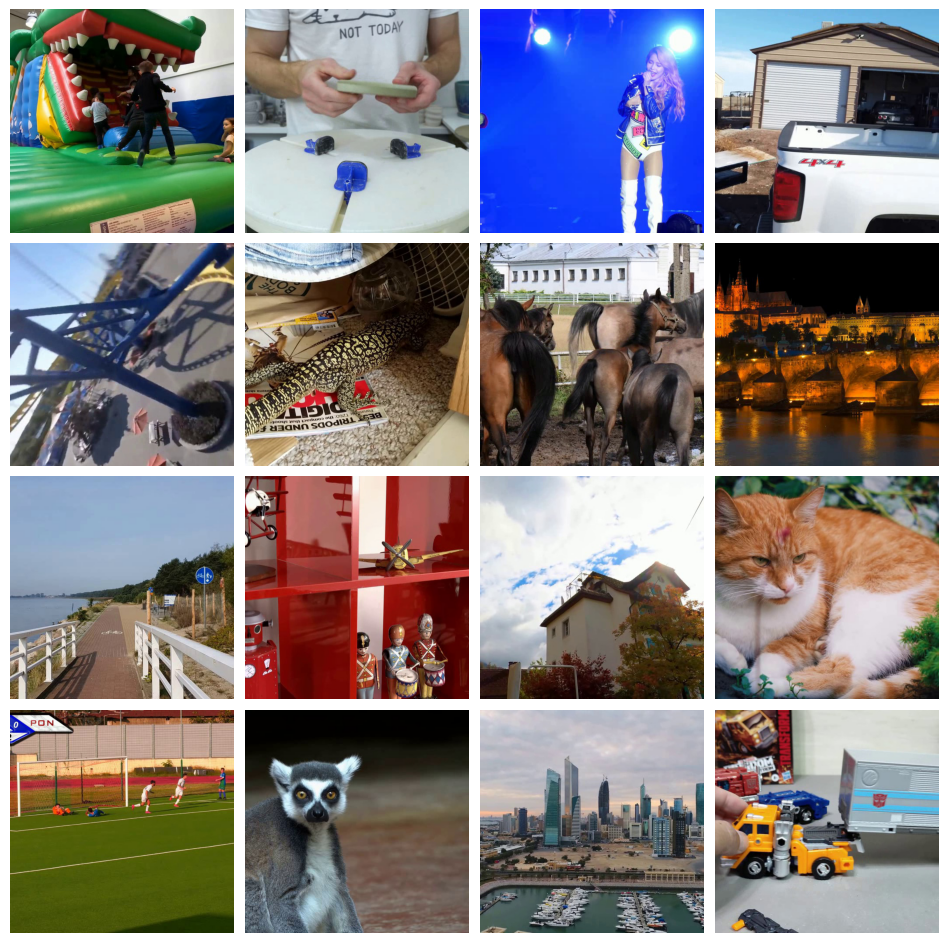

['videos/LDV3dataset/validation/cropped_512/322_512.mkv_rf_171.jpg', 'videos/LDV3dataset/validation/cropped_512/124_512.mkv_rf_46.jpg', 'videos/LDV3dataset/validation/cropped_512/026_512.mkv_rf_8.jpg', 'videos/LDV3dataset/validation/cropped_512/077_512.mkv_rf_262.jpg', 'videos/LDV3dataset/validation/cropped_512/110_512.mkv_rf_372.jpg', 'videos/LDV3dataset/validation/cropped_512/011_512.mkv_rf_55.jpg', 'videos/LDV3dataset/validation/cropped_512/293_512.mkv_rf_209.jpg', 'videos/LDV3dataset/validation/cropped_512/284_512.mkv_rf_161.jpg', 'videos/LDV3dataset/validation/cropped_512/138_512.mkv_rf_36.jpg', 'videos/LDV3dataset/validation/cropped_512/044_512.mkv_rf_15.jpg', 'videos/LDV3dataset/validation/cropped_512/150_512.mkv_rf_247.jpg', 'videos/LDV3dataset/validation/cropped_512/271_512.mkv_rf_210.jpg', 'videos/LDV3dataset/validation/cropped_512/349_512.mkv_rf_374.jpg', 'videos/LDV3dataset/validation/cropped_512/275_512.mkv_rf_554.jpg', 'videos/LDV3dataset/validation/cropped_512/076_512.mk

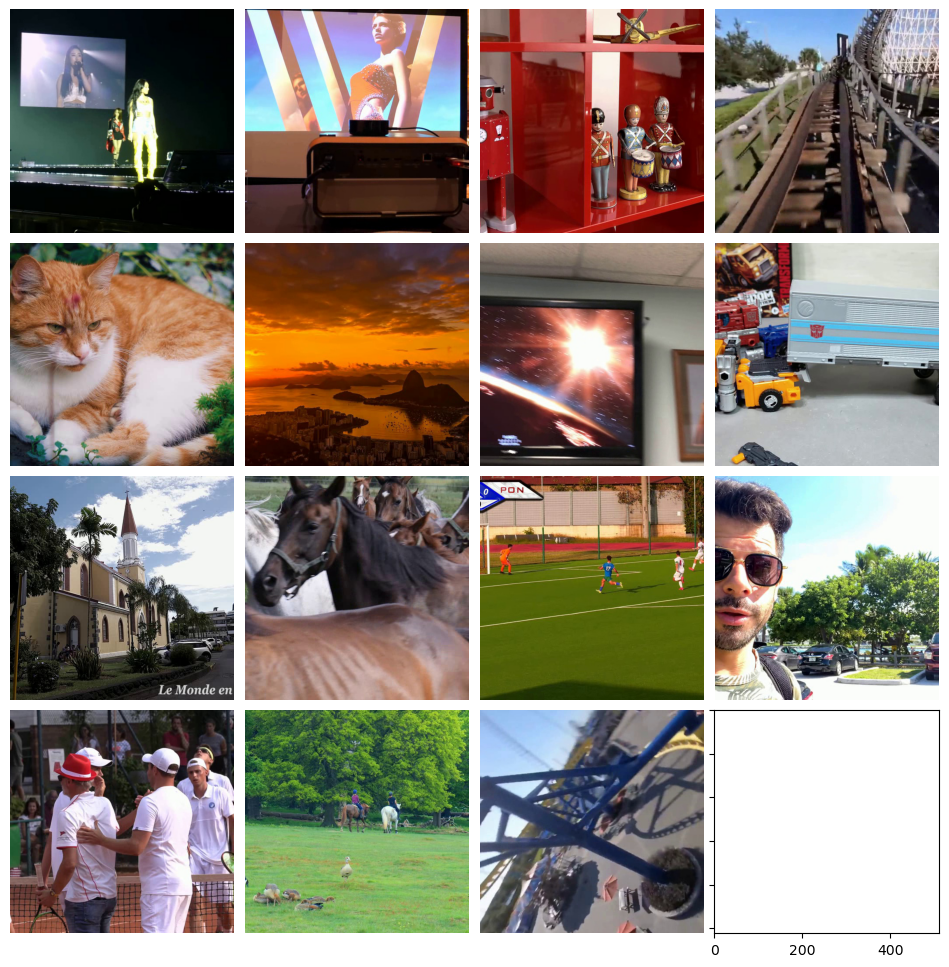

In [37]:
import os, random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg


frames = []
for file in os.scandir(f"videos/LDV3dataset/validation/cropped_512"):
    file_name, file_extension = os.path.splitext(file.name)
    if 'mkv' in file_extension:
        frames.append(file_name)

random.shuffle(frames)
frames = frames[:16]

frame_file = []
files = os.listdir(f"videos/LDV3dataset/validation/cropped_512")
random.shuffle(files)

random_frames = []
for frame in frames:
    for file in files:
        if frame in file and 'grid' not in file and 'jpg' in file:
            frame_file.append(f"videos/LDV3dataset/validation/cropped_512/{file}")
            break

print(frame_file)
fig = plt.figure(figsize=(12., 12.), dpi=100)
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.10, aspect=False)
for ax, im in zip(grid, frame_file):
    ax.axis('off')
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()
plt.close(fig)
